# Analisi Dataset Titanic

## import delle librerie 

In [418]:
import sys
import subprocess

# Assicura installazione plotly
try:
    import ipython
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "plotly", "--quiet"])


In [419]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb

## caricamento del dataset 

In [420]:
df = pd.read_csv('titanic_train.csv')

In [421]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Pulizia del dataset

In [422]:
# controllo righe mancanti 
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [423]:
df = df.fillna(df.median(numeric_only = True))
df = df.drop_duplicates()
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Encoding delle variabili

In [424]:
""" for col in df.select_dtypes(include='object'):
    df[col] = LabelEncoder().fit_transform(df[col]) """

" for col in df.select_dtypes(include='object'):\n    df[col] = LabelEncoder().fit_transform(df[col]) "

## Feature Engineering

In [ ]:
df = df.drop_duplicates()
df['Family'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['Family'] == 1).astype(int)

# Feature Title da Name
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
rare_titles = ['Dr','Rev','Col','Major','Count','Lady','Sir','Jonkheer','Don','Capt']
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

# Feature Deck da Cabin
df['Deck'] = df['Cabin'].str[0].fillna('Unknown')


" df = df.drop_duplicates()\ndf['Family'] = df['SibSp'] + df['Parch'] + 1\ndf['IsAlone'] = (df['Family'] == 1).astype(int)\n\n# Feature Title da Name\ndf['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\\.', expand=False)\ndf['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')\ndf['Title'] = df['Title'].replace('Mme', 'Mrs')\nrare_titles = ['Dr','Rev','Col','Major','Count','Lady','Sir','Jonkheer','Don','Capt']\ndf['Title'] = df['Title'].replace(rare_titles, 'Rare')\n\n# Feature Deck da Cabin\ndf['Deck'] = df['Cabin'].str[0].fillna('Unknown')\n "

## Rimuovere gli outlier 

In [426]:
""" num_cols = df.select_dtypes(include = 'number').columns
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1 

df = df[~((df < (Q1 - 1.5*IQR)) | (df > (Q3 + 1.5*IQR))).any(axis=1)] """

" num_cols = df.select_dtypes(include = 'number').columns\nQ1 = df.quantile(0.25)\nQ3 = df.quantile(0.75)\nIQR = Q3 - Q1 \n\ndf = df[~((df < (Q1 - 1.5*IQR)) | (df > (Q3 + 1.5*IQR))).any(axis=1)] "

In [427]:
for col in ['Fare', 'Age']:
    # Calcola IQR dopo aver imputato NaN (uso la mediana per Fare/Age solo per calcolare IQR)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
 
    df[col] = np.where(df[col] > upper_bound, upper_bound, 
                       np.where(df[col] < lower_bound, lower_bound, df[col]))



## Divisione feature e target

In [ ]:
X = df.drop(columns = ['Survived', 'PassengerId', 'Name', 'Embarked'])
y = df['Survived'] 

" X = df.drop(columns = ['Survived', 'PassengerId', 'Name', 'Embarked'])\ny = df['Survived'] "

In [430]:
# suddivisione dataset in train e test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [431]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family', 'IsAlone',
       'Title', 'Deck', 'Cabin_Count', 'Fare_Per_Person'],
      dtype='object')

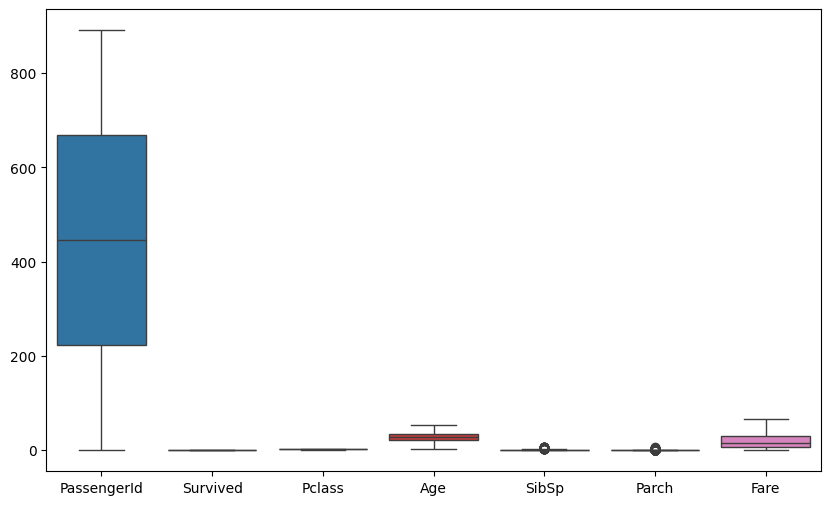

In [432]:
# valutazione della presenza di outlier 
plt.figure(figsize = (10, 6))
sns.boxplot(data=df[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']])
plt.show()

In [433]:
categorical_cols = df.select_dtypes(include = ['object']).columns.tolist()
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [434]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,IsAlone,Title,Deck,Cabin_Count,Fare_Per_Person
0,1,0,3,108,1,22.0,1,0,523,7.2500,147,2,2,0,2,8,0,3.6250
1,2,1,1,190,0,38.0,1,0,596,65.6344,81,0,2,0,3,2,1,32.8172
2,3,1,3,353,0,26.0,0,0,669,7.9250,147,2,1,1,1,8,0,7.9250
3,4,1,1,272,0,35.0,1,0,49,53.1000,55,2,2,0,3,2,1,26.5500
4,5,0,3,15,1,35.0,0,0,472,8.0500,147,2,1,1,2,8,0,8.0500


## Preprocessor

In [435]:
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Pipeline Numerica: Imputazione e Standardizzazione
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Gestisce NaN in Age/Fare
    ('scaler', StandardScaler())
])

# Pipeline Categorica: Imputazione e One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Gestisce NaN in Embarked/Title/Deck
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinazione
preprocessor_raw = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Ignora le colonne non specificate (come 'Sex' e 'Pclass' che sono già numeriche ma usate come 'object')
)

## Modelli

In [436]:
def objective_raw(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_jobs': -1,
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor_raw),
        ('model', model)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

    return scores.mean()


study_raw = optuna.create_study(direction='maximize')
study_raw.optimize(objective_raw, n_trials=50, show_progress_bar=True)

print(f"\nBest CV Accuracy: {study_raw.best_value:.4f}")
print("Best params:", study_raw.best_params)

[I 2025-12-05 13:15:20,879] A new study created in memory with name: no-name-9ddc698f-9f9f-4d34-8e29-bb828d1d5ee1
Best trial: 0. Best value: 0.817404:   2%|▏         | 1/50 [00:01<00:53,  1.10s/it]

[I 2025-12-05 13:15:21,977] Trial 0 finished with value: 0.8174037230375258 and parameters: {'n_estimators': 369, 'learning_rate': 0.19555902396269867, 'max_depth': 9, 'subsample': 0.6996110059888656, 'colsample_bytree': 0.6925518206242941, 'gamma': 1.2060858270042245, 'reg_alpha': 0.30343815615163705, 'reg_lambda': 0.00010863948905823835}. Best is trial 0 with value: 0.8174037230375258.


Best trial: 1. Best value: 0.824436:   4%|▍         | 2/50 [00:01<00:35,  1.34it/s]

[I 2025-12-05 13:15:22,473] Trial 1 finished with value: 0.8244361272530286 and parameters: {'n_estimators': 187, 'learning_rate': 0.15562961624458257, 'max_depth': 9, 'subsample': 0.947405957857463, 'colsample_bytree': 0.8712721119500029, 'gamma': 4.220368104765081, 'reg_alpha': 6.3156324835264925, 'reg_lambda': 0.00015481180739572656}. Best is trial 1 with value: 0.8244361272530286.


Best trial: 1. Best value: 0.824436:   6%|▌         | 3/50 [00:02<00:34,  1.38it/s]

[I 2025-12-05 13:15:23,173] Trial 2 finished with value: 0.8230473751600511 and parameters: {'n_estimators': 314, 'learning_rate': 0.262630335717947, 'max_depth': 3, 'subsample': 0.922773158626369, 'colsample_bytree': 0.9136155482138086, 'gamma': 4.09629459148937, 'reg_alpha': 1.0150027371017678e-08, 'reg_lambda': 6.3754181447050104}. Best is trial 1 with value: 0.8244361272530286.


Best trial: 3. Best value: 0.828661:   8%|▊         | 4/50 [00:03<00:34,  1.34it/s]

[I 2025-12-05 13:15:23,961] Trial 3 finished with value: 0.8286614793657048 and parameters: {'n_estimators': 182, 'learning_rate': 0.01016226896524596, 'max_depth': 4, 'subsample': 0.7751918767435706, 'colsample_bytree': 0.6507220266566583, 'gamma': 1.6244022986629303, 'reg_alpha': 8.590800049396886, 'reg_lambda': 0.16900848295814594}. Best is trial 3 with value: 0.8286614793657048.


Best trial: 3. Best value: 0.828661:  10%|█         | 5/50 [00:03<00:28,  1.57it/s]

[I 2025-12-05 13:15:24,400] Trial 4 finished with value: 0.8286614793657048 and parameters: {'n_estimators': 127, 'learning_rate': 0.11153650906415706, 'max_depth': 9, 'subsample': 0.9176087739635927, 'colsample_bytree': 0.9222002444165819, 'gamma': 3.8749351852250964, 'reg_alpha': 0.034955164870719944, 'reg_lambda': 0.001074053659943144}. Best is trial 3 with value: 0.8286614793657048.


Best trial: 3. Best value: 0.828661:  12%|█▏        | 6/50 [00:04<00:34,  1.29it/s]

[I 2025-12-05 13:15:25,451] Trial 5 finished with value: 0.821609376538954 and parameters: {'n_estimators': 555, 'learning_rate': 0.16575146940022475, 'max_depth': 6, 'subsample': 0.9268815023569341, 'colsample_bytree': 0.6276068590693495, 'gamma': 1.3563617726360566, 'reg_alpha': 0.08991489713293868, 'reg_lambda': 0.19730626488843528}. Best is trial 3 with value: 0.8286614793657048.


Best trial: 3. Best value: 0.828661:  14%|█▍        | 7/50 [00:04<00:28,  1.53it/s]

[I 2025-12-05 13:15:25,845] Trial 6 finished with value: 0.8244459765586527 and parameters: {'n_estimators': 105, 'learning_rate': 0.15513650053101827, 'max_depth': 3, 'subsample': 0.806545343989186, 'colsample_bytree': 0.9224475129588086, 'gamma': 3.5368137960734773, 'reg_alpha': 0.013276900686683578, 'reg_lambda': 0.008671622318233376}. Best is trial 3 with value: 0.8286614793657048.


Best trial: 3. Best value: 0.828661:  16%|█▌        | 8/50 [00:06<00:39,  1.07it/s]

[I 2025-12-05 13:15:27,394] Trial 7 finished with value: 0.8272530286614792 and parameters: {'n_estimators': 416, 'learning_rate': 0.08681017131945616, 'max_depth': 8, 'subsample': 0.6596957577397821, 'colsample_bytree': 0.6729751781713285, 'gamma': 0.6725087227439386, 'reg_alpha': 4.588970176366355e-07, 'reg_lambda': 1.8597206274191864e-06}. Best is trial 3 with value: 0.8286614793657048.


Best trial: 3. Best value: 0.828661:  18%|█▊        | 9/50 [00:07<00:36,  1.13it/s]

[I 2025-12-05 13:15:28,173] Trial 8 finished with value: 0.8216586230670739 and parameters: {'n_estimators': 301, 'learning_rate': 0.1595724582852397, 'max_depth': 9, 'subsample': 0.787847970692516, 'colsample_bytree': 0.7467601221605888, 'gamma': 1.0278631497357393, 'reg_alpha': 0.00020440435932949703, 'reg_lambda': 0.014569343391886603}. Best is trial 3 with value: 0.8286614793657048.


Best trial: 9. Best value: 0.835664:  20%|██        | 10/50 [00:08<00:34,  1.16it/s]

[I 2025-12-05 13:15:28,977] Trial 9 finished with value: 0.8356643356643356 and parameters: {'n_estimators': 309, 'learning_rate': 0.10812399927535406, 'max_depth': 3, 'subsample': 0.833593175074689, 'colsample_bytree': 0.7079719508860529, 'gamma': 0.8145086610462027, 'reg_alpha': 4.776439715801545e-07, 'reg_lambda': 0.010041596332974011}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  22%|██▏       | 11/50 [00:09<00:44,  1.15s/it]

[I 2025-12-05 13:15:30,766] Trial 10 finished with value: 0.8174234216487737 and parameters: {'n_estimators': 464, 'learning_rate': 0.037942543464665454, 'max_depth': 5, 'subsample': 0.8477178113858536, 'colsample_bytree': 0.8031239785235381, 'gamma': 0.07712624857833317, 'reg_alpha': 1.0783768874146657e-05, 'reg_lambda': 1.862742453327201e-08}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  24%|██▍       | 12/50 [00:10<00:39,  1.03s/it]

[I 2025-12-05 13:15:31,525] Trial 11 finished with value: 0.8314685314685315 and parameters: {'n_estimators': 220, 'learning_rate': 0.01635694413094326, 'max_depth': 4, 'subsample': 0.7334212968204437, 'colsample_bytree': 0.6245824606099747, 'gamma': 2.3428565340571677, 'reg_alpha': 0.00022346241873704106, 'reg_lambda': 1.1633516490690101}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  26%|██▌       | 13/50 [00:11<00:33,  1.10it/s]

[I 2025-12-05 13:15:32,161] Trial 12 finished with value: 0.8258642765685019 and parameters: {'n_estimators': 254, 'learning_rate': 0.0785499299599383, 'max_depth': 5, 'subsample': 0.7031346783740335, 'colsample_bytree': 0.734853267991671, 'gamma': 2.5512272703464633, 'reg_alpha': 6.386786358278551e-06, 'reg_lambda': 7.514312169481394}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  28%|██▊       | 14/50 [00:11<00:30,  1.19it/s]

[I 2025-12-05 13:15:32,831] Trial 13 finished with value: 0.8244065793361568 and parameters: {'n_estimators': 249, 'learning_rate': 0.053762590103392995, 'max_depth': 4, 'subsample': 0.6036616658151096, 'colsample_bytree': 0.6048571493602122, 'gamma': 2.4393128845083236, 'reg_alpha': 0.0007026861302302858, 'reg_lambda': 0.25549001991335146}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  30%|███       | 15/50 [00:12<00:26,  1.31it/s]

[I 2025-12-05 13:15:33,429] Trial 14 finished with value: 0.8258347286516301 and parameters: {'n_estimators': 231, 'learning_rate': 0.22507158474372624, 'max_depth': 7, 'subsample': 0.8486481934908396, 'colsample_bytree': 0.7716330706681686, 'gamma': 2.315542213457266, 'reg_alpha': 3.769584789787651e-08, 'reg_lambda': 3.633944320717343e-06}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  32%|███▏      | 16/50 [00:13<00:25,  1.32it/s]

[I 2025-12-05 13:15:34,172] Trial 15 finished with value: 0.8286516300600807 and parameters: {'n_estimators': 358, 'learning_rate': 0.112465599559502, 'max_depth': 4, 'subsample': 0.7311932263116753, 'colsample_bytree': 0.6996707390670241, 'gamma': 3.199547101581479, 'reg_alpha': 8.186264168162341e-05, 'reg_lambda': 0.012206703114751737}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  34%|███▍      | 17/50 [00:14<00:31,  1.03it/s]

[I 2025-12-05 13:15:35,627] Trial 16 finished with value: 0.8244262779474049 and parameters: {'n_estimators': 511, 'learning_rate': 0.013579252032017044, 'max_depth': 3, 'subsample': 0.862556823075546, 'colsample_bytree': 0.8193018712310034, 'gamma': 0.2359570030432836, 'reg_alpha': 6.657624000061991e-07, 'reg_lambda': 0.8301349481240762}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  36%|███▌      | 18/50 [00:15<00:27,  1.15it/s]

[I 2025-12-05 13:15:36,273] Trial 17 finished with value: 0.8244361272530286 and parameters: {'n_estimators': 303, 'learning_rate': 0.29868256370102525, 'max_depth': 6, 'subsample': 0.7488302932667508, 'colsample_bytree': 0.9864386455028593, 'gamma': 4.869649818752487, 'reg_alpha': 3.372332806021422e-07, 'reg_lambda': 0.0012719204419620815}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  38%|███▊      | 19/50 [00:16<00:27,  1.11it/s]

[I 2025-12-05 13:15:37,230] Trial 18 finished with value: 0.8300403821530583 and parameters: {'n_estimators': 415, 'learning_rate': 0.1124890442255383, 'max_depth': 5, 'subsample': 0.6384771283221303, 'colsample_bytree': 0.7178564014654137, 'gamma': 1.8695619153131469, 'reg_alpha': 0.0030611327849960667, 'reg_lambda': 0.03531457440987123}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  40%|████      | 20/50 [00:16<00:23,  1.29it/s]

[I 2025-12-05 13:15:37,724] Trial 19 finished with value: 0.8286614793657046 and parameters: {'n_estimators': 167, 'learning_rate': 0.056662128233914456, 'max_depth': 4, 'subsample': 0.987861692620476, 'colsample_bytree': 0.6024267636059061, 'gamma': 2.9723446504463786, 'reg_alpha': 1.3507776289095502e-05, 'reg_lambda': 2.1052062075073442e-05}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  42%|████▏     | 21/50 [00:17<00:20,  1.39it/s]

[I 2025-12-05 13:15:38,309] Trial 20 finished with value: 0.8174135723431497 and parameters: {'n_estimators': 224, 'learning_rate': 0.08284624366731277, 'max_depth': 7, 'subsample': 0.8250017751902256, 'colsample_bytree': 0.6528802558431157, 'gamma': 1.9514947835804408, 'reg_alpha': 1.6222027202278815e-06, 'reg_lambda': 1.1711157093976003}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  44%|████▍     | 22/50 [00:18<00:22,  1.26it/s]

[I 2025-12-05 13:15:39,274] Trial 21 finished with value: 0.8202304737516005 and parameters: {'n_estimators': 425, 'learning_rate': 0.1256120223676917, 'max_depth': 5, 'subsample': 0.6028817212070384, 'colsample_bytree': 0.7189061449523697, 'gamma': 1.7928908425701258, 'reg_alpha': 0.001554275327910097, 'reg_lambda': 0.04465041238984375}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  46%|████▌     | 23/50 [00:19<00:24,  1.09it/s]

[I 2025-12-05 13:15:40,489] Trial 22 finished with value: 0.8286811779769525 and parameters: {'n_estimators': 396, 'learning_rate': 0.12485287833660114, 'max_depth': 5, 'subsample': 0.6526512871448477, 'colsample_bytree': 0.7672626320500093, 'gamma': 0.7530702287030929, 'reg_alpha': 0.0025340551559562, 'reg_lambda': 0.002426458208018046}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  48%|████▊     | 24/50 [00:20<00:22,  1.16it/s]

[I 2025-12-05 13:15:41,209] Trial 23 finished with value: 0.8187924751305033 and parameters: {'n_estimators': 332, 'learning_rate': 0.20068776119477097, 'max_depth': 3, 'subsample': 0.6506982257508119, 'colsample_bytree': 0.674702744818216, 'gamma': 2.903754408365379, 'reg_alpha': 5.012802129095344e-05, 'reg_lambda': 0.0625331977734375}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  50%|█████     | 25/50 [00:21<00:23,  1.08it/s]

[I 2025-12-05 13:15:42,292] Trial 24 finished with value: 0.8258347286516301 and parameters: {'n_estimators': 481, 'learning_rate': 0.04229578664685897, 'max_depth': 4, 'subsample': 0.695530558680765, 'colsample_bytree': 0.829783499183183, 'gamma': 2.0384182085326548, 'reg_alpha': 0.004717362054532489, 'reg_lambda': 0.9203002239392275}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  52%|█████▏    | 26/50 [00:22<00:24,  1.03s/it]

[I 2025-12-05 13:15:43,551] Trial 25 finished with value: 0.8202206244459767 and parameters: {'n_estimators': 593, 'learning_rate': 0.09794050051274675, 'max_depth': 6, 'subsample': 0.8830585453667741, 'colsample_bytree': 0.7091964704795576, 'gamma': 0.5762093512600892, 'reg_alpha': 0.5586142174593461, 'reg_lambda': 0.004462271333788655}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  54%|█████▍    | 27/50 [00:23<00:21,  1.07it/s]

[I 2025-12-05 13:15:44,272] Trial 26 finished with value: 0.8272037821333595 and parameters: {'n_estimators': 270, 'learning_rate': 0.1338381570311268, 'max_depth': 5, 'subsample': 0.746560381093225, 'colsample_bytree': 0.6329463100125422, 'gamma': 1.4891141333561801, 'reg_alpha': 9.982422038621102e-08, 'reg_lambda': 0.043804248313470746}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  56%|█████▌    | 28/50 [00:24<00:19,  1.10it/s]

[I 2025-12-05 13:15:45,113] Trial 27 finished with value: 0.8314882300797792 and parameters: {'n_estimators': 375, 'learning_rate': 0.06708508394116935, 'max_depth': 3, 'subsample': 0.6807088220881073, 'colsample_bytree': 0.7580427237284255, 'gamma': 2.1806210988916943, 'reg_alpha': 0.0004218334470061349, 'reg_lambda': 2.0559665610001554}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  58%|█████▊    | 29/50 [00:24<00:17,  1.20it/s]

[I 2025-12-05 13:15:45,786] Trial 28 finished with value: 0.825844577957254 and parameters: {'n_estimators': 286, 'learning_rate': 0.06734097968704068, 'max_depth': 3, 'subsample': 0.7675859176759564, 'colsample_bytree': 0.7707552624662303, 'gamma': 2.6176106794184775, 'reg_alpha': 0.00016756667707385335, 'reg_lambda': 3.334347888058785}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  60%|██████    | 30/50 [00:25<00:17,  1.13it/s]

[I 2025-12-05 13:15:46,785] Trial 29 finished with value: 0.8314389835516597 and parameters: {'n_estimators': 374, 'learning_rate': 0.028609563286101328, 'max_depth': 3, 'subsample': 0.6908130103508399, 'colsample_bytree': 0.6811050162056874, 'gamma': 1.259458902935162, 'reg_alpha': 3.024451354282621e-06, 'reg_lambda': 1.7835030926039575}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  62%|██████▏   | 31/50 [00:27<00:19,  1.00s/it]

[I 2025-12-05 13:15:48,059] Trial 30 finished with value: 0.8244262779474048 and parameters: {'n_estimators': 345, 'learning_rate': 0.027858404476151094, 'max_depth': 10, 'subsample': 0.7126871774081601, 'colsample_bytree': 0.8535334753564204, 'gamma': 1.0586860601089638, 'reg_alpha': 5.0969070451813335e-05, 'reg_lambda': 0.2520460387015226}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  64%|██████▍   | 32/50 [00:28<00:18,  1.03s/it]

[I 2025-12-05 13:15:49,150] Trial 31 finished with value: 0.8328671328671329 and parameters: {'n_estimators': 379, 'learning_rate': 0.03568564390580943, 'max_depth': 3, 'subsample': 0.6786479400304136, 'colsample_bytree': 0.6906164094846874, 'gamma': 1.1165620081652463, 'reg_alpha': 5.104640386730624e-06, 'reg_lambda': 1.9624221861418063}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  66%|██████▌   | 33/50 [00:29<00:19,  1.12s/it]

[I 2025-12-05 13:15:50,493] Trial 32 finished with value: 0.825824879346006 and parameters: {'n_estimators': 377, 'learning_rate': 0.06572584717720431, 'max_depth': 4, 'subsample': 0.6781962812368838, 'colsample_bytree': 0.7558111777644475, 'gamma': 0.3775533181347812, 'reg_alpha': 2.2340411170509955e-05, 'reg_lambda': 8.8827735769324}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  68%|██████▊   | 34/50 [00:30<00:17,  1.07s/it]

[I 2025-12-05 13:15:51,444] Trial 33 finished with value: 0.8244361272530287 and parameters: {'n_estimators': 450, 'learning_rate': 0.052164400023252226, 'max_depth': 3, 'subsample': 0.7191584153410256, 'colsample_bytree': 0.6567745572991626, 'gamma': 2.2063619094278843, 'reg_alpha': 1.1916825826276829e-07, 'reg_lambda': 0.48658023730362354}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  70%|███████   | 35/50 [00:31<00:15,  1.03s/it]

[I 2025-12-05 13:15:52,378] Trial 34 finished with value: 0.8258347286516301 and parameters: {'n_estimators': 322, 'learning_rate': 0.030646995046628434, 'max_depth': 3, 'subsample': 0.8115243123976839, 'colsample_bytree': 0.6950335796188872, 'gamma': 0.9002709119580202, 'reg_alpha': 3.3245835889766862e-06, 'reg_lambda': 2.214531361075799}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  72%|███████▏  | 36/50 [00:32<00:12,  1.09it/s]

[I 2025-12-05 13:15:53,039] Trial 35 finished with value: 0.8202206244459767 and parameters: {'n_estimators': 190, 'learning_rate': 0.093196775717138, 'max_depth': 4, 'subsample': 0.625190825892639, 'colsample_bytree': 0.789547074599189, 'gamma': 1.545329862846323, 'reg_alpha': 0.0007746480733661134, 'reg_lambda': 0.00038368210082853816}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  74%|███████▍  | 37/50 [00:32<00:11,  1.14it/s]

[I 2025-12-05 13:15:53,815] Trial 36 finished with value: 0.8258642765685019 and parameters: {'n_estimators': 207, 'learning_rate': 0.012475851497305936, 'max_depth': 3, 'subsample': 0.6710378983281103, 'colsample_bytree': 0.7283596847480127, 'gamma': 2.811686090174064, 'reg_alpha': 0.00043887727696499635, 'reg_lambda': 7.327837263952675e-05}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  76%|███████▌  | 38/50 [00:33<00:09,  1.33it/s]

[I 2025-12-05 13:15:54,282] Trial 37 finished with value: 0.8272628779671034 and parameters: {'n_estimators': 137, 'learning_rate': 0.0684508995049552, 'max_depth': 4, 'subsample': 0.7462107675871148, 'colsample_bytree': 0.6209963174712751, 'gamma': 3.3422281817105746, 'reg_alpha': 1.1353441959144887e-08, 'reg_lambda': 0.12962819327645256}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  78%|███████▊  | 39/50 [00:34<00:08,  1.24it/s]

[I 2025-12-05 13:15:55,201] Trial 38 finished with value: 0.8328474342558849 and parameters: {'n_estimators': 345, 'learning_rate': 0.18035562437323027, 'max_depth': 3, 'subsample': 0.7852960485989818, 'colsample_bytree': 0.6454922208407289, 'gamma': 1.226932758559684, 'reg_alpha': 1.028266698254005e-06, 'reg_lambda': 4.1313165748211205}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  80%|████████  | 40/50 [00:35<00:08,  1.14it/s]

[I 2025-12-05 13:15:56,264] Trial 39 finished with value: 0.8230375258544272 and parameters: {'n_estimators': 391, 'learning_rate': 0.18853881759627844, 'max_depth': 3, 'subsample': 0.8927804823472822, 'colsample_bytree': 0.6695228022785736, 'gamma': 1.2463046545661949, 'reg_alpha': 1.075373412662561e-06, 'reg_lambda': 4.232015305494513}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  82%|████████▏ | 41/50 [00:36<00:08,  1.05it/s]

[I 2025-12-05 13:15:57,368] Trial 40 finished with value: 0.8132079188417217 and parameters: {'n_estimators': 345, 'learning_rate': 0.17911949301904126, 'max_depth': 3, 'subsample': 0.7741729370108208, 'colsample_bytree': 0.7410825739683676, 'gamma': 0.5086839505056556, 'reg_alpha': 1.3540827950679482e-07, 'reg_lambda': 4.505045107430208e-08}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  84%|████████▍ | 42/50 [00:37<00:07,  1.08it/s]

[I 2025-12-05 13:15:58,246] Trial 41 finished with value: 0.8272431793558553 and parameters: {'n_estimators': 281, 'learning_rate': 0.23073545353810745, 'max_depth': 4, 'subsample': 0.7959999154501806, 'colsample_bytree': 0.6409392356218494, 'gamma': 0.9196327518512852, 'reg_alpha': 0.012960391963890821, 'reg_lambda': 0.5392894656412748}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  86%|████████▌ | 43/50 [00:38<00:06,  1.14it/s]

[I 2025-12-05 13:15:59,005] Trial 42 finished with value: 0.8244262779474049 and parameters: {'n_estimators': 317, 'learning_rate': 0.14196116797693914, 'max_depth': 3, 'subsample': 0.81834131629518, 'colsample_bytree': 0.6936948243158703, 'gamma': 1.6856497930307974, 'reg_alpha': 2.3242003906134638e-05, 'reg_lambda': 2.618151944978254}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  88%|████████▊ | 44/50 [00:39<00:06,  1.12s/it]

[I 2025-12-05 13:16:00,676] Trial 43 finished with value: 0.8286713286713286 and parameters: {'n_estimators': 434, 'learning_rate': 0.045174397384806816, 'max_depth': 4, 'subsample': 0.7261483697579939, 'colsample_bytree': 0.6607820922685415, 'gamma': 0.01691160775837597, 'reg_alpha': 4.457254335932304e-06, 'reg_lambda': 0.09965034251666284}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  90%|█████████ | 45/50 [00:40<00:05,  1.06s/it]

[I 2025-12-05 13:16:01,611] Trial 44 finished with value: 0.8272431793558553 and parameters: {'n_estimators': 373, 'learning_rate': 0.20950308057579348, 'max_depth': 3, 'subsample': 0.7794252788765842, 'colsample_bytree': 0.6279804520383309, 'gamma': 1.395780847241052, 'reg_alpha': 2.778308953059857e-07, 'reg_lambda': 8.22202908165055}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  92%|█████████▏| 46/50 [00:41<00:03,  1.03it/s]

[I 2025-12-05 13:16:02,387] Trial 45 finished with value: 0.8202206244459764 and parameters: {'n_estimators': 395, 'learning_rate': 0.16979156658859565, 'max_depth': 4, 'subsample': 0.8357595343947005, 'colsample_bytree': 0.6836246728779215, 'gamma': 2.162423286296308, 'reg_alpha': 2.8320265997297128e-08, 'reg_lambda': 0.3437688398160765}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  94%|█████████▍| 47/50 [00:42<00:02,  1.12it/s]

[I 2025-12-05 13:16:03,098] Trial 46 finished with value: 0.821609376538954 and parameters: {'n_estimators': 252, 'learning_rate': 0.1464298175791462, 'max_depth': 8, 'subsample': 0.7621433160856446, 'colsample_bytree': 0.611025418980885, 'gamma': 1.0232425386973736, 'reg_alpha': 0.00011383621770757924, 'reg_lambda': 1.117209809633777}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  96%|█████████▌| 48/50 [00:43<00:01,  1.05it/s]

[I 2025-12-05 13:16:04,174] Trial 47 finished with value: 0.8272333300502315 and parameters: {'n_estimators': 485, 'learning_rate': 0.10399583965444129, 'max_depth': 3, 'subsample': 0.7972842213351727, 'colsample_bytree': 0.6423642074318788, 'gamma': 0.8135224464242304, 'reg_alpha': 0.7914350870365461, 'reg_lambda': 3.7215503802620358}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664:  98%|█████████▊| 49/50 [00:43<00:00,  1.15it/s]

[I 2025-12-05 13:16:04,848] Trial 48 finished with value: 0.8314783807741554 and parameters: {'n_estimators': 301, 'learning_rate': 0.07737824755154415, 'max_depth': 4, 'subsample': 0.6774170384727017, 'colsample_bytree': 0.7554167179942027, 'gamma': 3.8793273778846418, 'reg_alpha': 0.0003710639078660638, 'reg_lambda': 0.12521839011761857}. Best is trial 9 with value: 0.8356643356643356.


Best trial: 9. Best value: 0.835664: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]

[I 2025-12-05 13:16:05,639] Trial 49 finished with value: 0.8272628779671033 and parameters: {'n_estimators': 303, 'learning_rate': 0.07906647472449631, 'max_depth': 3, 'subsample': 0.6251615918464262, 'colsample_bytree': 0.7990157556020204, 'gamma': 4.221476155835084, 'reg_alpha': 0.05981362698242702, 'reg_lambda': 0.01180270290010273}. Best is trial 9 with value: 0.8356643356643356.

Best CV Accuracy: 0.8357
Best params: {'n_estimators': 309, 'learning_rate': 0.10812399927535406, 'max_depth': 3, 'subsample': 0.833593175074689, 'colsample_bytree': 0.7079719508860529, 'gamma': 0.8145086610462027, 'reg_alpha': 4.776439715801545e-07, 'reg_lambda': 0.010041596332974011}


In [ ]:
# ================================
# TRAINING MODELLO RAW FINALE
# ================================


best_params_raw = study_raw.best_params


final_pipeline_raw = Pipeline(steps=[
    ('preprocessor', preprocessor_raw),
    ('model', xgb.XGBClassifier(**best_params_raw, random_state=42, use_label_encoder=False))
])

# Fitting sul train set
final_pipeline_raw.fit(X_train, y_train)

# Predizioni sul test set
y_pred_raw = final_pipeline_raw.predict(X_test)

# Accuracy
acc_raw = accuracy_score(y_test, y_pred_raw)

# ================================
# STAMPA RISULTATI
# ================================
prev_fe_acc = 0.8400 

print("\n" + "="*50)
print(" RISULTATI DELLO STUDIO DI ABLAZIONE ")
print("="*50)
print(f"Modello con Feature Engineering (Prev.):  {prev_fe_acc:.4f}") 
print(f"Modello su Dati Raw (Attuale):           {acc_raw:.4f}")
print("-" * 50)
delta = (prev_fe_acc - acc_raw) * 100
print(f"Delta Performance: {delta:.2f} punti percentuali persi")
print("="*50)



 RISULTATI DELLO STUDIO DI ABLAZIONE 
Modello con Feature Engineering (Prev.):  0.8400
Modello su Dati Raw (Attuale):           0.8268
--------------------------------------------------
Delta Performance: 1.32 punti percentuali persi



Generazione Matrice di Confusione...


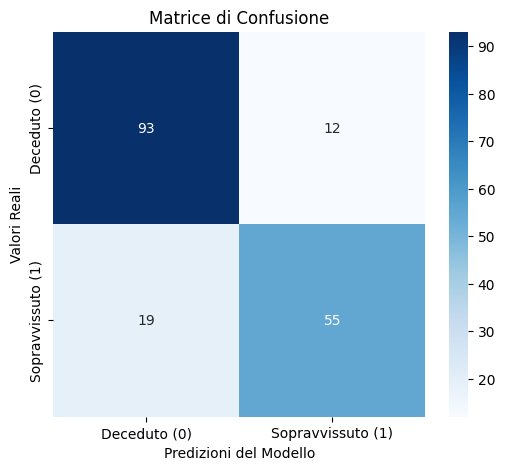

In [438]:
### A. Matrice di Confusione (CM)
from sklearn.metrics import confusion_matrix
print("\nGenerazione Matrice di Confusione...")
cm = confusion_matrix(y_test, y_pred_raw)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Deceduto (0)','Sopravvissuto (1)'], 
            yticklabels=['Deceduto (0)','Sopravvissuto (1)'])
plt.title("Matrice di Confusione")
plt.ylabel("Valori Reali")
plt.xlabel("Predizioni del Modello")
plt.show() # 


Generazione Curva di Apprendimento (Diagnosi Bias/Varianza)...


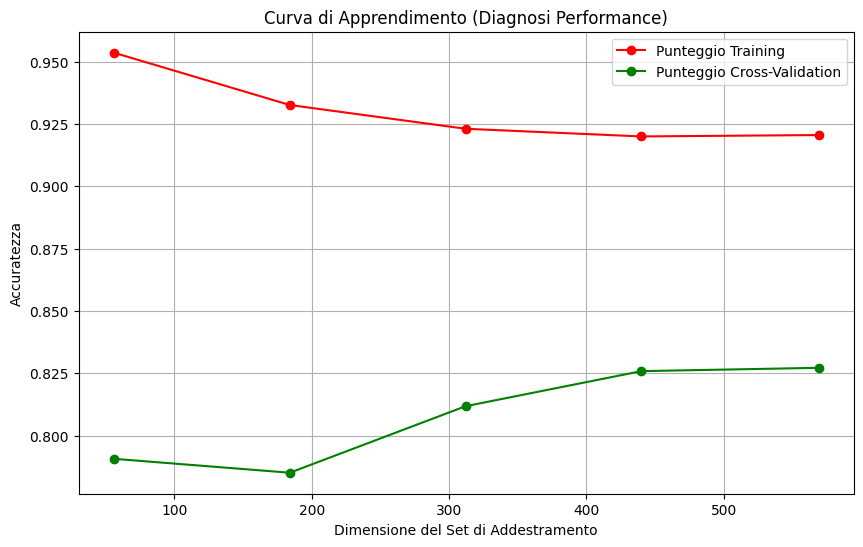

In [ ]:
## B. Curva di Apprendimento
print("\nGenerazione Curva di Apprendimento (Diagnosi Bias/Varianza)...")
try:
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=final_pipeline_raw, 
        X=X_train, y=y_train, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
        n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), 
        scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Punteggio Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Punteggio Cross-Validation")
    plt.title("Curva di Apprendimento (Diagnosi Performance)")
    plt.xlabel("Dimensione del Set di Addestramento")
    plt.ylabel("Accuratezza")
    plt.grid()
    plt.legend(loc="best")
    plt.show() 

except Exception as e:
    print(f"Errore nella Curva di Apprendimento: {e}")